In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import binom
import pickle
from sklearn.cluster import KMeans
exec(open('../../analysis/ppVAF_calculations/ppVAF_utils.py').read())

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory 
data_dir = ""

# directory where the purity data and the table with clonal counts and polyclonal calls are saved
# defaults to path in repo relative to current WD
repo_data_dir = "../../data/"

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

annot_dir = "../../data/scATACseq_annotations/"
purity_dict = pickle.load(open(annot_dir+"scATAC_purities.p", "rb"))
sc_types = pd.read_csv(annot_dir+"scATAC_celltype_fracs.csv", index_col=0)

In [3]:
filtered_maf_WGS = pd.read_csv(data_dir+"HTAN_WGS_filtered_ppVAFs.maf", sep="\t")
filtered_maf_WES = pd.read_csv(data_dir+"HTAN_WES_filtered_ppVAFs.maf", sep="\t")

clonal_count_dir = repo_data_dir+"clonal_count_estimation/"
expected_clonal = pd.read_csv(clonal_count_dir+"clonal_SNVs_WES_WGS.csv", index_col=0)

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,87,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
HTAN_WGS_CN_purity = pd.read_csv(repo_data_dir+"HTAN_WGS_facets_sequenza_purities.csv", index_col=0)
HTAN_WES_CN_purity = pd.read_csv(repo_data_dir+"HTAN_WES_facets_sequenza_purities.csv", index_col=0)

HTAN_WGS_CN_purity = HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"] != "AdCa"]
HTAN_WES_CN_purity = HTAN_WES_CN_purity[HTAN_WES_CN_purity["stage"] != "AdCa"]

In [5]:
sim_results_dir = repo_data_dir + "purity_sims/"

purity_sweep = [round(x, 2) for x in np.linspace(0.1, 0.95, 18)]

for i,purity in enumerate(purity_sweep):
    to_add = pd.read_csv(sim_results_dir+"frac_"+str(purity)+".csv")
    if i == 0:
        sim_data = to_add
    else:
        sim_data = pd.concat([sim_data, to_add])

In [6]:
def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data.astype("boolean")), np.sum(~binom_data.astype("boolean")))

def plot_dist(maf, active_ax, plot_var="vaf", group_var=None, purity=None, common_norm=True, plot_color="darkgrey", xlabel=None, plot_drivers=False):
    if group_var is None:
        sns.kdeplot(x=maf[plot_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
    else:
        sns.kdeplot(x=maf[plot_var], hue=maf[group_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
        
    if purity is not None:
        active_ax.axvline(x=purity/2, color="k")
    active_ax.set_xlim(0,1)
    if xlabel is not None:
        active_ax.set_xlabel(xlabel, fontsize=12)
    active_ax.set_ylabel("Density", fontsize=12)
    
    if plot_drivers:
        drivers = maf[maf["Driver"]]
        for vaf in drivers[drivers["Hugo_Symbol"]=="APC"]["vaf"]:
            active_ax.axvline(x=vaf, color="r")
        for vaf in drivers[drivers["Hugo_Symbol"]=="KRAS"]["vaf"]:
            active_ax.axvline(x=vaf, color="orange")
    return

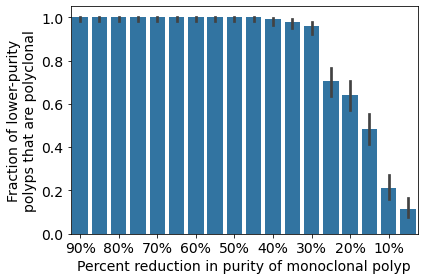

In [7]:
# FIG SN2.1a

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=sim_data["mix_frac"], y=sim_data["is_poly"], errorbar=compute_errorbars, ax=ax, color="tab:blue")
plt.xlabel("Percent reduction in purity of monoclonal polyp", fontsize=14)
plt.ylabel("Fraction of lower-purity\npolyps that are polyclonal", fontsize=14)
plt.xticks(ticks=np.arange(9)*2, labels=[str(-x)+"%" for x in np.arange(-9, 0)*10], fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST6a_purity_sim_raw.pdf")
plt.show()

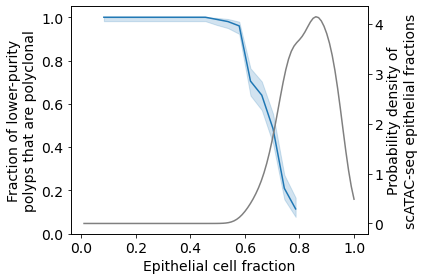

In [8]:
# FIG SN2.1b

avg_purity = np.mean(sc_types[sc_types["DiseaseState"]=="Polyp"]["epithelial"])

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.lineplot(x=sim_data["mix_frac"] * avg_purity, y=sim_data["is_poly"], errorbar=compute_errorbars, ax=ax)
ax2 = plt.twinx()
sns.lineplot(x=np.linspace(0.01, 1, 100), y=purity_dict["Benign"]*100, ax=ax2, color="grey")

ax.set_xlabel("Epithelial cell fraction", fontsize=14)
ax.set_ylabel("Fraction of lower-purity\npolyps that are polyclonal", fontsize=14)
ax2.set_ylabel("Probability density of\nscATAC-seq epithelial fractions", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(0,1.05)

plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST6b_purity_sim_convolve.pdf")
plt.show()

In [9]:
sim_data["purity"] = sim_data["mix_frac"] * avg_purity
to_convolve = sim_data.groupby("purity").mean()

purity_convolve = [purity_dict["Benign"][0]]
for i in to_convolve.index:
    purity_convolve.append(purity_dict["Benign"][int(np.ceil(100*i))])
purity_convolve.append(purity_dict["Benign"][int(np.ceil(100*avg_purity))])

prob_poly_convolve = [1] + to_convolve["is_poly"].tolist()+[0]
x_convolve = [0] + to_convolve.index.tolist() + [avg_purity]
false_pos_frac = np.trapz(y= np.array(prob_poly_convolve) * np.array(purity_convolve) * 100, x=x_convolve)
print("Expected false polyclonal rate due to purity misestimation:", false_pos_frac)

Expected false polyclonal rate due to purity misestimation: 0.14868924509486833


In [10]:
sc_types["sample_match"] = ["".join(x.split("-")) for x in sc_types.index]

all_intersected = list(set(sc_types["sample_match"]).intersection(set(filtered_maf_WGS["Tumor_Sample_Barcode"])))


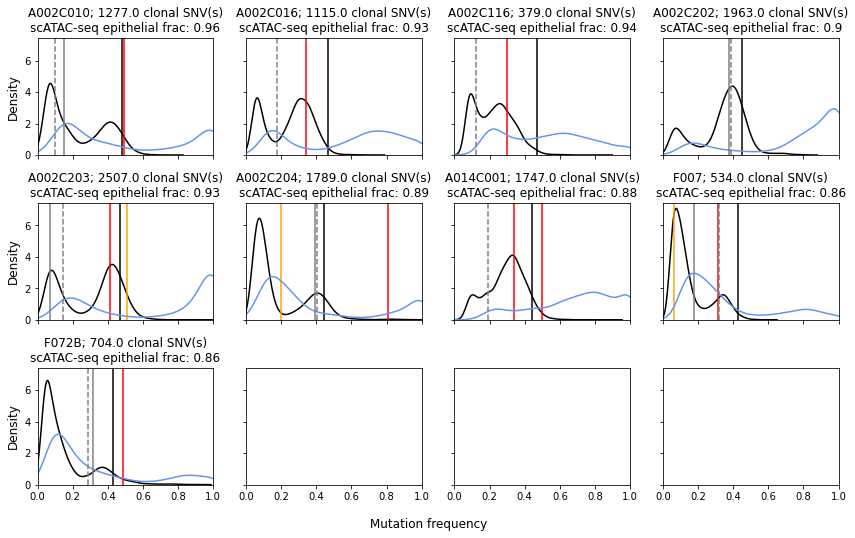

In [11]:
# FIG SN2.2

to_plot = expected_clonal[np.logical_and(expected_clonal["stage"]=="Dysplasia", ~expected_clonal["is_poly"])].index
to_plot = filtered_maf_WGS[np.isin(filtered_maf_WGS["Tumor_Sample_Barcode"], to_plot)]
to_plot = to_plot[np.isin(to_plot["Tumor_Sample_Barcode"], all_intersected)]

sample_names = sorted(list(set(to_plot["Tumor_Sample_Barcode"])))

ncol = 4
nrow = int(np.ceil(len(sample_names)/ncol))
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*3, nrow*2.5), sharex=True, sharey=True)
for i,sample in enumerate(sample_names):
    if nrow == 1:
        active_ax = axs[i]
    else:
        active_ax = axs[int(i/ncol), i%ncol]
    sample_plot = to_plot[to_plot["Tumor_Sample_Barcode"]==sample]
    sc_purity = sc_types[sc_types["sample_match"]==sample]["epithelial"][0]
    plot_dist(sample_plot, active_ax, plot_var="vaf", plot_color="k", plot_drivers=True, purity=sc_purity)
    plot_dist(sample_plot, active_ax, plot_var="ppVAF", plot_color="cornflowerblue", xlabel="")
    active_ax.axvline(x=HTAN_WGS_CN_purity.loc[sample]["purity_sequenza"]/2, color="grey", linestyle="dashed")
    active_ax.axvline(x=HTAN_WGS_CN_purity.loc[sample]["purity_facets"]/2, color="grey")

    print_clonals = round(expected_clonal.loc[sample]["final_clonal_WGS"], 2)
    if print_clonals <=1:
        print_clonals = "<= 1"
    active_ax.set_title(sample+"; "+str(print_clonals)+" clonal SNV(s)\nscATAC-seq epithelial frac: "+str(round(sc_purity,2)))
fig.supxlabel('Mutation frequency')
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST7_sharedATAC_dysplasia_mono_WGS.pdf")
    plt.savefig(plots_dir+"FigST7_sharedATAC_dysplasia_mono_WGS.jpg")
plt.show()

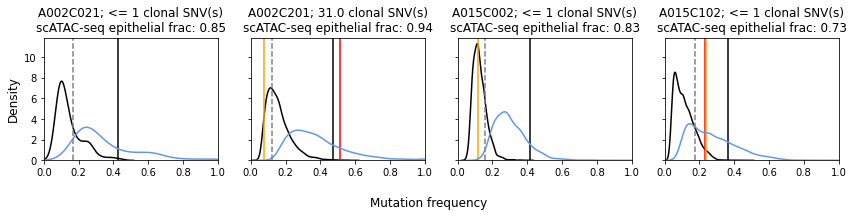

In [12]:
# FIG SN2.3

to_plot = expected_clonal[np.logical_and(expected_clonal["stage"]=="Dysplasia", expected_clonal["is_poly"])].index
to_plot = filtered_maf_WGS[np.isin(filtered_maf_WGS["Tumor_Sample_Barcode"], to_plot)]
to_plot = to_plot[np.isin(to_plot["Tumor_Sample_Barcode"], all_intersected)]

sample_names = sorted(list(set(to_plot["Tumor_Sample_Barcode"])))

ncol = 4
nrow = int(np.ceil(len(sample_names)/ncol))
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*3, nrow*3), sharex=True, sharey=True)
for i,sample in enumerate(sample_names):
    if nrow == 1:
        active_ax = axs[i]
    else:
        active_ax = axs[int(i/ncol), i%ncol]
    sample_plot = to_plot[to_plot["Tumor_Sample_Barcode"]==sample]
    sc_purity = sc_types[sc_types["sample_match"]==sample]["epithelial"][0]
    plot_dist(sample_plot, active_ax, plot_var="vaf", plot_color="k", plot_drivers=True, purity=sc_purity)
    plot_dist(sample_plot, active_ax, plot_var="ppVAF", plot_color="cornflowerblue", xlabel="")
    active_ax.axvline(x=HTAN_WGS_CN_purity.loc[sample]["purity_sequenza"]/2, color="grey", linestyle="dashed")
    active_ax.axvline(x=HTAN_WGS_CN_purity.loc[sample]["purity_facets"]/2, color="grey")

    print_clonals = round(expected_clonal.loc[sample]["final_clonal_WGS"], 2)
    if print_clonals <=1:
        print_clonals = "<= 1"
    active_ax.set_title(sample+"; "+str(print_clonals)+" clonal SNV(s)\nscATAC-seq epithelial frac: "+str(round(sc_purity,2)))
fig.supxlabel('Mutation frequency')
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST8_sharedATAC_dysplasia_poly_WGS.pdf")
    plt.savefig(plots_dir+"FigST8_sharedATAC_dysplasia_poly_WGS.jpg")
plt.show()

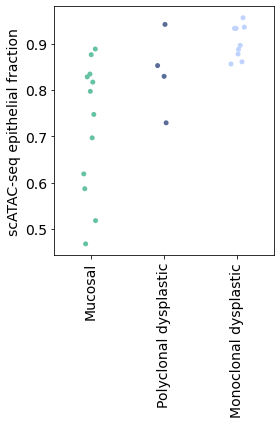

In [13]:
# FIG SN2.4

sample_to_stage = dict(zip(filtered_maf_WGS["Tumor_Sample_Barcode"], filtered_maf_WGS["Stage"]))
rename_cats = {"Dysplasia_True":"Polyclonal dysplastic", "Dysplasia_False":"Monoclonal dysplastic", "Mucosa_True":"Mucosal"}

scATAC_intersected = [sc_types[sc_types["sample_match"]==x]["epithelial"][0] for x in all_intersected]
scATAC_intersected = pd.DataFrame({"purity":scATAC_intersected, "stage":[sample_to_stage[x] for x in all_intersected]})
scATAC_intersected["is_poly"] = [expected_clonal.loc[x]["is_poly"] for x in all_intersected]

scATAC_intersected = scATAC_intersected[np.isin(scATAC_intersected["stage"], ["Mucosa", "Dysplasia"])]
scATAC_intersected["plot_cat"] = [scATAC_intersected.iloc[i]["stage"]+"_"+str(scATAC_intersected.iloc[i]["is_poly"]) for i in range(len(scATAC_intersected))]
scATAC_intersected["plot_cat"] = [rename_cats[x] for x in scATAC_intersected["plot_cat"]]

benign_mono_color = np.array(set2_colors[1]) + np.array([0, 0.2, 0.2])
benign_poly_color = np.array(set2_colors[1]) - np.array([0, 0.2, 0.2])

dysplastic_mono_color = np.array(set2_colors[2]) + np.array([0.2, 0.2, 0.2])
dysplastic_poly_color = np.array(set2_colors[2]) - np.array([0.2, 0.2, 0.2])

categories_plot = ["Mucosal", "Polyclonal dysplastic", "Monoclonal dysplastic"]
palette_plot = dict(zip(categories_plot, [set2_colors[0], dysplastic_poly_color, dysplastic_mono_color]))

fig, ax = plt.subplots(1,1,figsize=(4, 6))
sns.stripplot(x=scATAC_intersected["plot_cat"], y=scATAC_intersected["purity"], hue=scATAC_intersected["plot_cat"], order=categories_plot, palette=palette_plot, ax=ax, legend=None)
plt.xlabel("")
plt.ylabel("scATAC-seq epithelial fraction", fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST9_epi_fracs.pdf")
    plt.savefig(plots_dir+"FigST9_epi_fracs.jpg")
plt.show()

In [ ]:
print(stats.mannwhitneyu(scATAC_intersected[scATAC_intersected["plot_cat"]=="Monoclonal dysplastic"]["purity"], scATAC_intersected[scATAC_intersected["plot_cat"]=="Polyclonal dysplastic"]["purity"]))